In [1]:
# Download Yellow Taxi Trip Records" for January and February 2022.
!wget -nc -O ./data/jan.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet
!wget -nc -O ./data/feb.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-02.parquet

File ‘./data/jan.parquet’ already there; not retrieving.
File ‘./data/feb.parquet’ already there; not retrieving.


# Setup

In [46]:
import pickle
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
df = pd.read_parquet("./data/jan.parquet")
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [4]:
df.shape

(2463931, 19)

## Compute duration

In [5]:
# Duration in minutes
df["duration"] = (
    df.tpep_dropoff_datetime - df.tpep_pickup_datetime
).dt.total_seconds() / 60.0
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0,17.816667
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0,8.400000
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0,8.966667
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0,10.033333
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0,37.533333


In [6]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99]).apply(lambda x: round(x, 2))

count    2463931.00
mean          14.21
std           46.45
min        -3442.40
50%           10.18
95%           31.93
98%           42.15
99%           50.85
max         8513.18
Name: duration, dtype: float64

In [7]:
df[df.duration < 0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
1809900,1,2022-01-24 15:23:01,2022-01-22 06:00:37,1.0,4.70,1.0,N,140,152,4,17.00,3.0,0.5,0.0,0.0,0.3,20.80,2.5,0.0,-3442.400000
2392571,6,2022-01-01 01:01:54,2022-01-01 01:01:36,NaN,10.72,NaN,None,265,254,0,44.20,0.0,0.5,0.0,0.0,0.3,45.00,NaN,NaN,-0.300000
2392642,6,2022-01-01 01:01:44,2022-01-01 01:01:20,NaN,2.06,NaN,None,265,41,0,40.20,0.0,0.5,0.0,0.0,0.3,41.00,NaN,NaN,-0.400000
2393302,6,2022-01-01 04:01:37,2022-01-01 04:01:19,NaN,15.73,NaN,None,265,213,0,38.29,0.0,0.5,0.0,0.0,0.3,39.09,NaN,NaN,-0.300000
2393327,6,2022-01-01 04:01:23,2022-01-01 04:01:12,NaN,4.17,NaN,None,265,244,0,15.20,0.0,0.5,0.0,0.0,0.3,16.00,NaN,NaN,-0.183333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463554,6,2022-01-31 20:01:42,2022-01-31 20:01:24,NaN,10.86,NaN,None,265,63,0,45.23,0.0,0.5,0.0,0.0,0.3,46.03,NaN,NaN,-0.300000
2463568,6,2022-01-31 20:01:48,2022-01-31 20:01:37,NaN,1.98,NaN,None,265,75,0,25.20,0.0,0.5,0.0,0.0,0.3,26.00,NaN,NaN,-0.183333
2463631,6,2022-01-31 20:01:54,2022-01-31 20:01:31,NaN,8.88,NaN,None,265,130,0,39.92,0.0,0.5,0.0,0.0,0.3,40.72,NaN,NaN,-0.383333
2463817,6,2022-01-31 22:01:32,2022-01-31 22:01:18,NaN,14.34,NaN,None,265,210,0,44.73,0.0,0.5,0.0,0.0,0.3,45.53,NaN,NaN,-0.233333


## Remove outliers

keep only the records where the duration was between 1 and 60 minutes (inclusive).

In [8]:
df_removed = df[(df.duration >= 1) & (df.duration <= 60)]

In [9]:
# The percentage of outliers
len(df_removed) / len(df) * 100

98.27547930522405

## One-hot encoding

Apply one-hot encoding to the pickup (`PULocationID`) and dropoff location IDs (`DOLocationID`). 

We'll use only these two features for our model.
- Turn the dataframe into a list of dictionaries
- Fit a dictionary vectorizer
- Get a feature matrix from it

In [10]:
categorical = ['PULocationID', 'DOLocationID']

In [11]:
df_removed[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [12]:
df_removed[categorical] = df_removed[categorical].astype(str)

/tmp/ipykernel_11068/1365444284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_removed[categorical] = df_removed[categorical].astype(str)


In [13]:
df_removed[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [14]:
train_dict = df_removed[categorical].to_dict(orient="records")
train_dict[:5]

[{'PULocationID': '142', 'DOLocationID': '236'},
 {'PULocationID': '236', 'DOLocationID': '42'},
 {'PULocationID': '166', 'DOLocationID': '166'},
 {'PULocationID': '114', 'DOLocationID': '68'},
 {'PULocationID': '68', 'DOLocationID': '163'}]

In [15]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

In [16]:
X_train.shape

(2421440, 515)

In [45]:
dv.get_feature_names_out()[:10]

array(['DOLocationID=1', 'DOLocationID=10', 'DOLocationID=100',
       'DOLocationID=101', 'DOLocationID=102', 'DOLocationID=105',
       'DOLocationID=106', 'DOLocationID=107', 'DOLocationID=108',
       'DOLocationID=109'], dtype=object)

## Training a model

- Train a plain linear regression model with default parameters
- Calculate the RMSE of the model on the training data

In [23]:
target = 'duration'
y_train = df_removed[target].values

In [24]:
y_train.shape

(2421440,)

In [26]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [27]:
y_pred = linear_model.predict(X_train)

print(f'Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}')

Train RMSE: 6.986190742248472


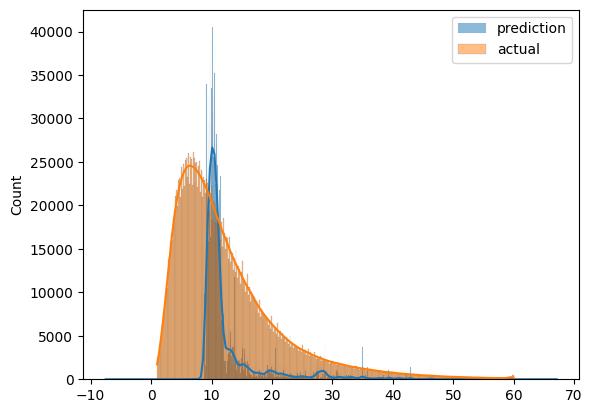

In [33]:
sns.histplot(y_pred, kde=True, label='prediction')
sns.histplot(y_train, kde=True, label='actual')

plt.legend();

## Evaluating the model

In [36]:
def read_dataframe(path):
    df = pd.read_parquet(path)
    df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.total_seconds() / 60.0
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    return df

In [37]:
df_val = read_dataframe("./data/feb.parquet")

In [38]:
val_dict = df_val[categorical].to_dict(orient='records')

In [41]:
X_val = dv.transform(val_dict)
y_val = df_val.duration.values

In [42]:
y_pred = linear_model.predict(X_val)

In [43]:
print(f'Val RMSE: {mean_squared_error(y_val, y_pred, squared=False)}')

Val RMSE: 7.78640662117552


## Save the model

In [47]:
with open("models/lin_reg.bin", "wb") as f:
    pickle.dump((dv, linear_model), f)